In [ ]:
!pip install pandas numpy scikit-learn nltk matplotlib seaborn keras tensorflow

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading data

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:00<00:00, 113MB/s]
100% 80.9M/80.9M [00:00<00:00, 95.8MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# Load the dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Assign column names
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [ ]:
#Info of the dataset
print('length of data is', len(df))

length of data is 1600000


In [ ]:
df.info()

#Check for missing values
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,0
target,0
id,0
date,0
flag,0
user,0
text,0


Sampling

In [ ]:
# Separate positive and negative samples (assuming 'target' column contains sentiment labels)
positive_samples = df[df['target'] == 4]  # Assuming 4 represents positive sentiment
negative_samples = df[df['target'] == 0]  # Assuming 0 represents negative sentiment

# Sample an equal number of positives and negatives
n_samples = 200000
positive_sampled = positive_samples.sample(n=n_samples, random_state=1)
negative_sampled = negative_samples.sample(n=n_samples, random_state=1)

# Combine and shuffle the samples
senti140_reduced = pd.concat([positive_sampled, negative_sampled]).sample(frac=1, random_state=1).reset_index(drop=True)

print("Balanced dataset created with {} positive and {} negative samples.".format(n_samples, n_samples))

Balanced dataset created with 200000 positive and 200000 negative samples.


In [ ]:
# Keep only the 'target' and 'text' columns
senti140_reduced = senti140_reduced[['target', 'text']]
senti140_reduced.head()

,target,text
0,4,http://twitpic.com/5opnc - my hobby photography
1,4,@_everaldo what desks did you order? iDesk? Mi...
2,4,Moka (Mocha) my little kitty is just stayin w/...
3,4,"@sophienetter ahaha, why doesn't that surprise..."
4,4,I also managed to stop by the golf range today...


Pre-processing

In [ ]:
# Define the text cleaning Regex
TEXT_CLEANING_RE = "@\w+|https?://\S+|[^A-Za-z0-9]+"

# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Pre-process function
def preprocess(text):
    # Remove link, user, and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

# Apply preprocessing to the text data
senti140_reduced['text'] = senti140_reduced['text'].apply(preprocess)
print("Preprocessing completed.")

Preprocessing completed.


In [ ]:
senti140_reduced.head()

,target,text
0,4,hobby photography
1,4,desk order idesk milk
2,4,moka mocha little kitty stayin w never leaving...
3,4,ahaha surprise lucky charm time lt 3 adore
4,4,also managed stop golf range today first time ...


Preparing data for SVM and LSTM

In [ ]:
#Vectorize the data for SVM
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X_svm = vectorizer.fit_transform(senti140_reduced['text'])
y_svm = senti140_reduced['target'].apply(lambda x: 1 if x == 4 else 0)

In [ ]:
#Prepare the data for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(senti140_reduced['text'])
X_lstm = tokenizer.texts_to_sequences(senti140_reduced['text'])
X_lstm = pad_sequences(X_lstm, maxlen=max_len)
y_lstm = y_svm.values

SVM

In [ ]:
#Train the SVM model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm,
                                        y_svm, test_size=0.2, random_state=1)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train_svm)
y_pred_svm = svm_model.predict(X_test_svm)

svm_accuracy = accuracy_score(y_test_svm, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.7675


LSTM

In [ ]:
#Train the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm,
                                        y_lstm, test_size=0.2, random_state=1)

model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32,
                    validation_data=(X_test_lstm, y_test_lstm))

lstm_accuracy = model.evaluate(X_test_lstm, y_test_lstm)[1]
print(f'LSTM Accuracy: {lstm_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.5992 - loss: 0.6576 - val_accuracy: 0.6935 - val_loss: 0.5720
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 136ms/step - accuracy: 0.8115 - loss: 0.4261 - val_accuracy: 0.7045 - val_loss: 0.5796
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.8803 - loss: 0.3022 - val_accuracy: 0.7000 - val_loss: 0.6554
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9058 - loss: 0.2425 - val_accuracy: 0.6920 - val_loss: 0.7829
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9341 - loss: 0.1681 - val_accuracy: 0.6910 - val_loss: 0.8952
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7022 - loss: 0.8837
LSTM Accuracy: 0.6910


Hybrid Model

In [ ]:
#Combine predictions for a hybrid model
svm_pred_prob = svm_model.decision_function(X_test_svm)
svm_pred_prob = (svm_pred_prob - svm_pred_prob.min()) /(svm_pred_prob.max() - svm_pred_prob.min())

lstm_pred_prob = model.predict(X_test_lstm).flatten()

combined_pred = (svm_pred_prob + lstm_pred_prob) / 2
combined_pred = (combined_pred > 0.5).astype(int)

hybrid_accuracy = accuracy_score(y_test_svm, combined_pred)
print(f'Hybrid Model Accuracy: {hybrid_accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
Hybrid Model Accuracy: 0.6990


In [ ]:
#classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_svm, combined_pred))

Visualizations

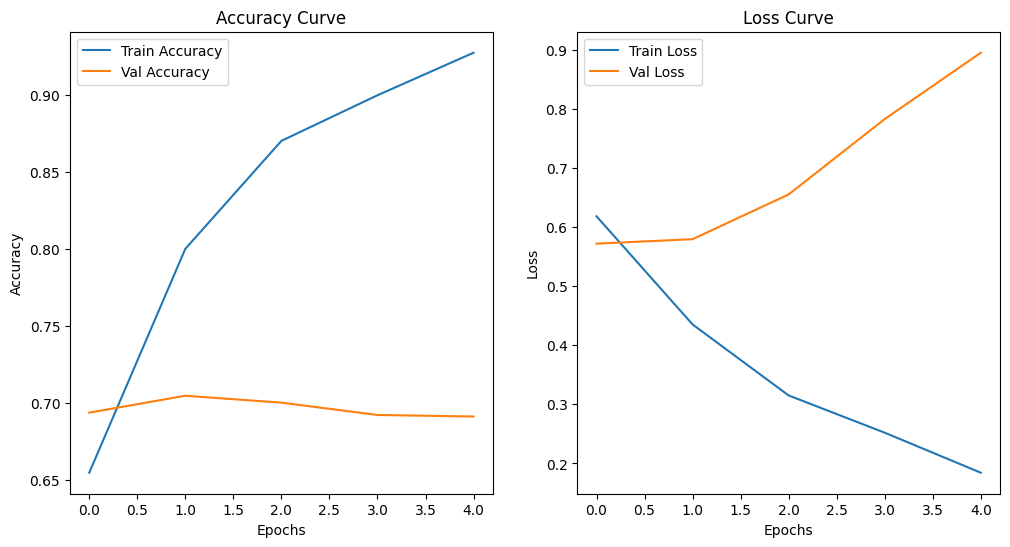

In [ ]:
#Accuracy and Loss Curves for LSTM
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

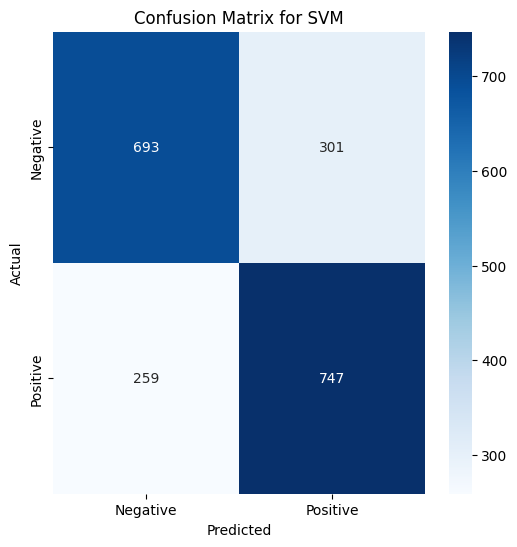

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step


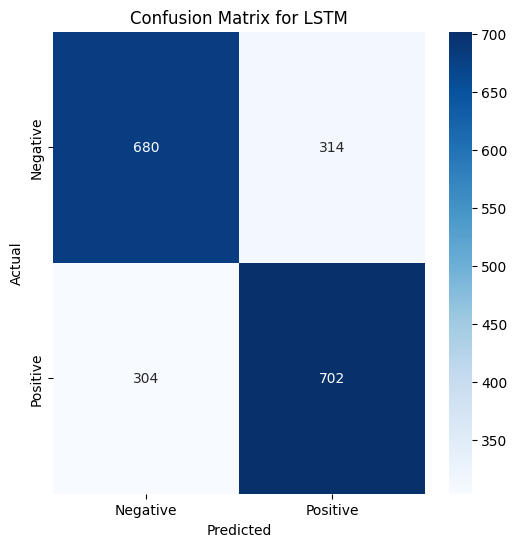

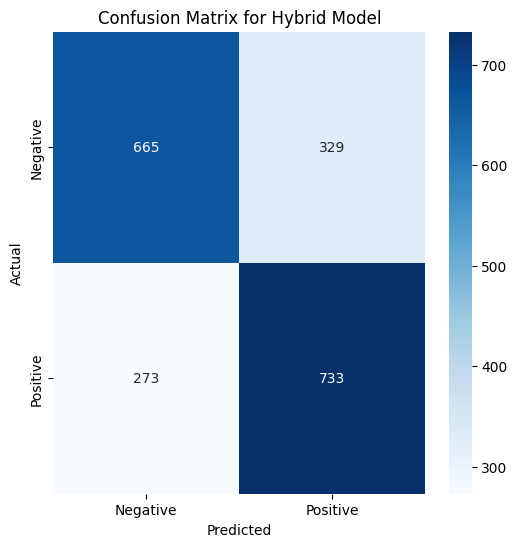

In [ ]:
#Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test_svm, y_pred_svm, 'Confusion Matrix for SVM')
plot_confusion_matrix(y_test_lstm, (model.predict(X_test_lstm).flatten() > 0.5).astype(int), 'Confusion Matrix for LSTM')
plot_confusion_matrix(y_test_svm, combined_pred, 'Confusion Matrix for Hybrid Model')

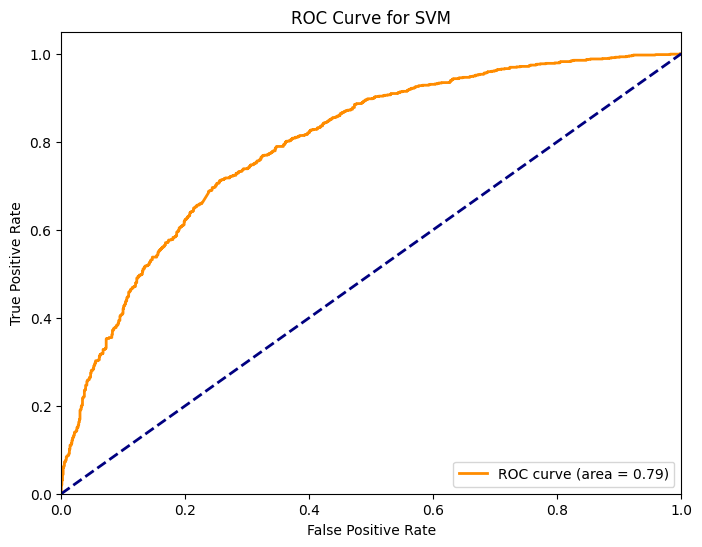

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


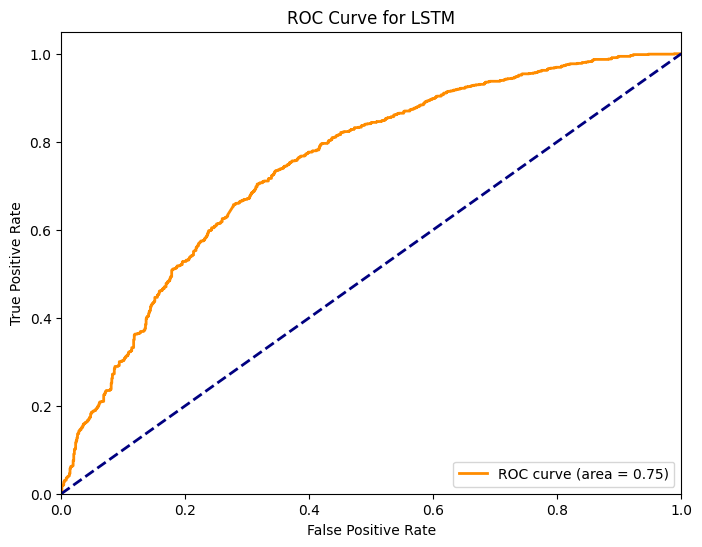

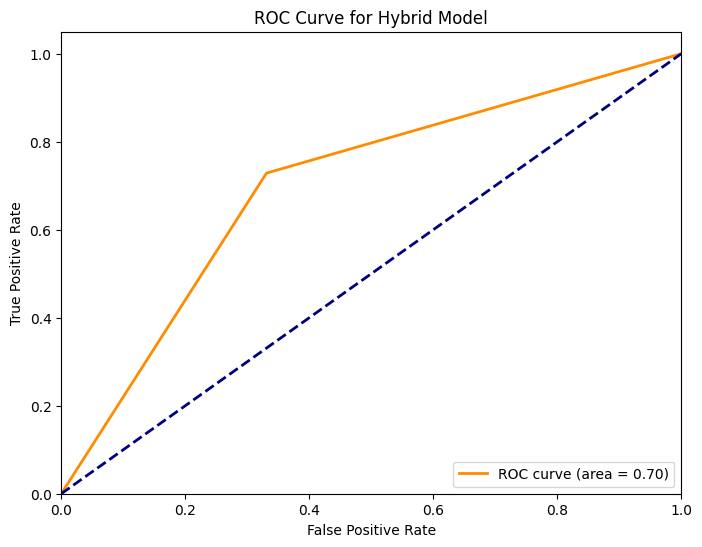

In [ ]:
#ROC Curve and AUC Score
def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test_svm, svm_pred_prob, 'ROC Curve for SVM')
plot_roc_curve(y_test_lstm, model.predict(X_test_lstm).flatten(), 'ROC Curve for LSTM')
plot_roc_curve(y_test_svm, combined_pred, 'ROC Curve for Hybrid Model')


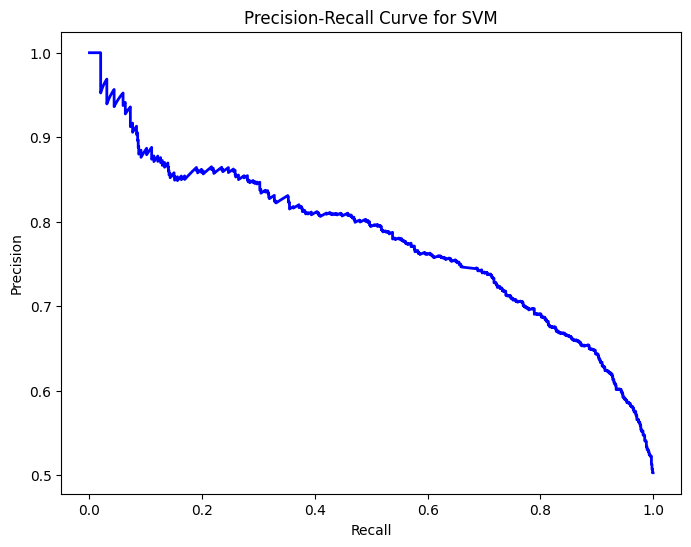

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


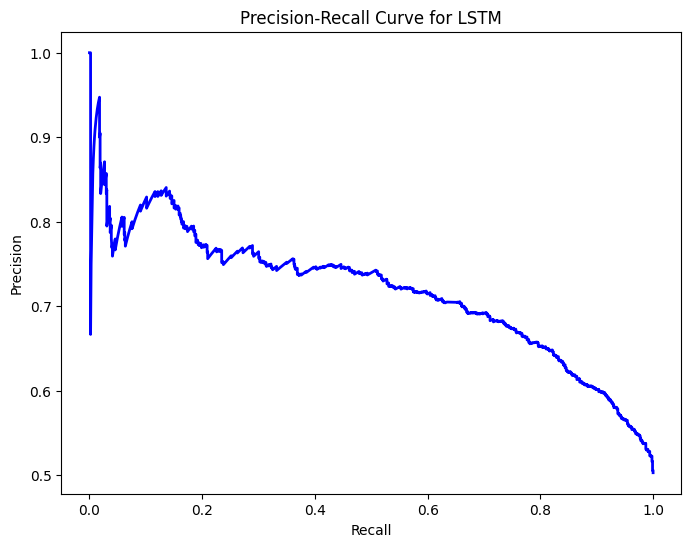

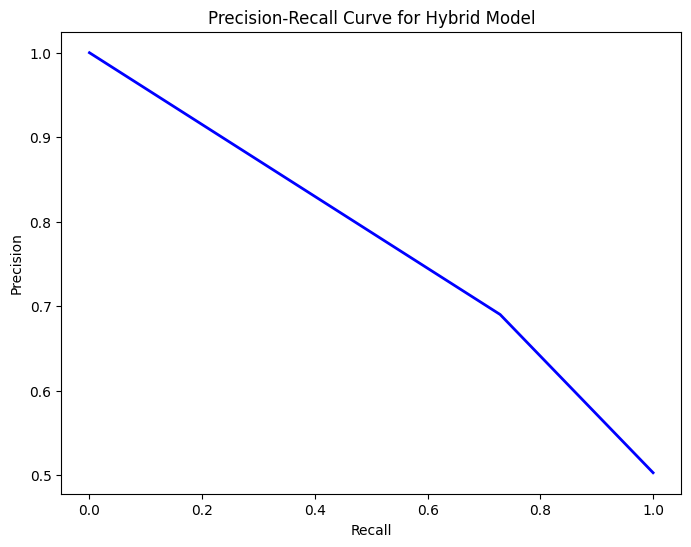

In [ ]:
# 5. Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_pred_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

plot_precision_recall_curve(y_test_svm, svm_pred_prob, 'Precision-Recall Curve for SVM')
plot_precision_recall_curve(y_test_lstm, model.predict(X_test_lstm).flatten(), 'Precision-Recall Curve for LSTM')
plot_precision_recall_curve(y_test_svm, combined_pred, 'Precision-Recall Curve for Hybrid Model')